In [1]:
import pandas as pd
import import_ipynb
import analysis_utils as utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

importing Jupyter notebook from analysis_utils.ipynb


#### CRISP-DM: BSINESS UNDERSTANDING
This excersize is based on airbnb data for Boston and Seattle in 2016-17. The aim of this excersize is threefold.

**1.** Explore data included in listings dataset to check what city is on average more expensive to visit: Boston or Seattle.

**2.** Explore what attributes included in listings data set have largest predictive power. In particulate, what matters most airbnb review scores or physical attributes of properties.

**3.** Explore data included in calander data set in order to analyse the price seasonality in both cities and the pricce time trend.

#### STEP 1. LOAD AND CLEAN AIRBNB DATA FOR SEATTLE AND BOSTON

In [2]:
# Set pandas formating options
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.width = 2000
pd.options.display.max_columns = 10

In [3]:
# 1.1. load airbnb data using UDF
data_type = ['calendar'
             , 'listings'
             , 'reviews']

city_type = ['seattle'
             , 'boston']

city_dictionary = utils.load_csv(city_type, data_type, 'data')

In [4]:
# 1.2. create separate dataframes for each city and data set
reviews_df = utils.concatenate_dataframes(city_dictionary, 'reviews')
calendar_df = utils.concatenate_dataframes(city_dictionary, 'calendar')
listings_df = utils.concatenate_dataframes(city_dictionary, 'listings')

# Convert host_since_year to numetic value
listings_df['host_since_year'] = pd.to_numeric(listings_df['host_since_year'], errors='coerce')

#### CRISP-DM: DATA UNDERSTANDING
After the innitial assessment of the data there are several findings:

**Listings dataset**

**1.** Price attribute was recorded as a string type with dollar sign, therefore, I created a separate attributed called price_float equal to the float price stripped of dollar sign and converted to type float.

**2.** Listings data set has a roughly similar amount of data both for Boston and Seattle: about 3.5K observations and 99 attributs.

**3.** Boston data has a significant amount of attributes that have more than 50 percent of data missing. For instance, license or jurisdiction_names. Seattle data has similar cases but as many. 


**Calendar dataset**


**1.** In calendar data set attributes date and host_since were recorded as a string type so I separated each into three separate attributes: year, month, day.

**2.** In calendar data I have about 600K observations for Boston and 900K for Seattle.

**3.** Most of Seattle data is coming from 2016 while most of Boston data is from 2017.

**4.** Price_float is the only attribute that have missing values in calendar dataset.

#### STEP 2. ASSESS SIZE OF THE DATA AND THE AMOUNT OF MISSING DATA
**1.** Check listing data to use in price prediction excersize


In [5]:
# 2.1.1.  check shape of the listings df
print(listings_df[listings_df['boston'] == 1].shape)
print(listings_df[listings_df['boston'] == 0].shape)
# seattle has slighlty more observations

(3585, 99)
(3818, 99)


In [6]:
# 2.1.2 check missing data in listing df
# create a list of columns that have more than 50% of missing data to drop then later
columns_with_missing_values = utils.check_missing_values(listings_df, 0.5)

                               index  seattle  boston
51                           license     1.00    1.00
15                jurisdiction_names     0.00    1.00
20      neighbourhood_group_cleansed     0.00    1.00
46                  has_availability     0.00    1.00
68                       square_feet     0.97    0.98
23               monthly_price_float     0.60    0.75
63                     monthly_price     0.60    0.75
59                weekly_price_float     0.47    0.75
94                      weekly_price     0.47    0.75
90                  security_deposit     0.51    0.63
70                             notes     0.42    0.55
3              neighborhood_overview     0.27    0.39
8                         host_about     0.22    0.37
74                           transit     0.24    0.36
53                      cleaning_fee     0.27    0.31
14                             space     0.15    0.29
45            review_scores_accuracy     0.17    0.23
13            review_scores_

In [7]:
# 2.1.3. Check missing data in categorical series only
string_columns = list(set(listings_df.select_dtypes(include=['object']).columns)) + ['boston']
utils.check_missing_values(listings_df[string_columns], 0.5)

                               index  seattle  boston
26                jurisdiction_names     0.00    1.00
37      neighbourhood_group_cleansed     0.00    1.00
53                  has_availability     0.00    1.00
22                     monthly_price     0.60    0.75
51                      weekly_price     0.47    0.75
38                  security_deposit     0.51    0.63
43                             notes     0.42    0.55
4              neighborhood_overview     0.27    0.39
13                        host_about     0.22    0.37
55                           transit     0.24    0.36
45                      cleaning_fee     0.27    0.31
24                             space     0.15    0.29
5                        last_review     0.16    0.21
18                      first_review     0.16    0.21
15                    xl_picture_url     0.08    0.17
30                        medium_url     0.08    0.17
42                     thumbnail_url     0.08    0.17
11                     neigh

['jurisdiction_names',
 'neighbourhood_group_cleansed',
 'has_availability',
 'monthly_price',
 'weekly_price',
 'security_deposit',
 'notes']

In [8]:
# 2.1.4. Check missing data in numerical series only
numeric_columns = list(set(listings_df.select_dtypes(include=['int64','float64']).columns))
utils.check_missing_values(listings_df[numeric_columns], 0.5)

                             index  seattle  boston
33                         license     1.00    1.00
22                     square_feet     0.97    0.98
20             monthly_price_float     0.60    0.75
6               weekly_price_float     0.47    0.75
28          review_scores_accuracy     0.17    0.23
11          review_scores_location     0.17    0.23
16             review_scores_value     0.17    0.23
4            review_scores_checkin     0.17    0.23
3        review_scores_cleanliness     0.17    0.23
10     review_scores_communication     0.17    0.23
15            review_scores_rating     0.17    0.23
19               reviews_per_month     0.16    0.21
5                        bathrooms     0.00    0.00
13                        bedrooms     0.00    0.00
30                            beds     0.00    0.00
2              host_listings_count     0.00    0.00
8                  host_since_year     0.00    0.00
9        host_total_listings_count     0.00    0.00
0           

['license', 'square_feet', 'monthly_price_float', 'weekly_price_float']


**2.** Check calendar data to use in study price seasonality and time trend

In [9]:
# 2.2.1. Check missing data in calendar df
utils.check_missing_values(calendar_df, 0.5) 

         index  seattle  boston
4        price     0.33    0.51
8  price_float     0.33    0.51
0    date_year     0.00    0.00
1   date_month     0.00    0.00
2    available     0.00    0.00
3     date_day     0.00    0.00
5       boston     0.00    0.00
6         date     0.00    0.00
7   listing_id     0.00    0.00


['price', 'price_float']

In [10]:
print(calendar_df[calendar_df['boston'] == 1].shape)
print(calendar_df[calendar_df['boston'] == 0].shape)
# seattle has slighlty more observations

(1308890, 9)
(1393570, 9)


In [11]:
#Most of Seattle data is coming from 2016 while most of Boston data is from 2017
calendar_df['2017_year'] = np.where(calendar_df['date_year'] == '2017', 1, 0)
calendar_df.groupby(['boston','2017_year'])['date_month'].value_counts()

boston  2017_year  date_month
0       0          03            118358
                   05            118358
                   07            118358
                   08            118358
                   10            118358
                   12            118358
                   04            114540
                   06            114540
                   09            114540
                   11            114540
                   02            110722
                   01            106904
        1          01              7636
1       0          10            111166
                   12            111166
                   11            107580
                   09             89650
        1          01            111166
                   03            111166
                   05            111166
                   07            111166
                   08            111166
                   04            107580
                   06            107580
          

#### CRISP-DM: DATA PREPARATION PART 1

After the innitial assessment of the data there are several findings:

**Listings dataset**

**1.** Boston data has a significant amount of attributes that have more than 50 percent of data missing. For instance, license or jurisdiction_names. Seattle data has similar cases but as many. I decided to drop the attributes that have more than 50 percent of missing data in any city from the data set. If I keep these attributes but drop the records with missing values I will loose more than a half of the data set. In addition, jusdjing by their names they don't seem to be important for price prediction excersize.

**2.** There was also a number of attibutes related to scrapping of the data, their name contained url and scrap strings so I decided to drop them.

**3.** In addition, there was a significant amount of categoriacal data that judjing by their names does not have a predictive power for price. So I combined them as exclude_columns and dropped them.

**4.** Among numeric attributes there are several that had about 20 percent of missing values in both cities. All of them are associated with review scores. For instance, review_scores_accuracy or review_scores. 

I had to decide either to impute missing values or drop these receords or drop the columns. Since I am particularly interested in relationship between review attributes and price I decided not to drop these columns.

Instead, I decided to impute the missing values with mean values of the attributes. The advantage is that I do not loose 20 percent of observations. The disadvantage is that I create a synthetic values and that can influence my estimations. 

Since imputing missing values with a mean estimate is a relatevely save approach because it does not create a bias for a coefficient estimate in either direction, I decided to impute missing values and utilize other information that is contained in other attributes of these records for my estimations.

**5.** Among categorical attributes only host_response_time had about 13 percent of missing data. Since, imputing categorical variables is not possible I had to decide if I want to drop the column or to drop the records with missing values. I decided to drop the records since the dataset is large enough.


**Calendar dataset**

**1.** In calendar data I have about 600K observations for Boston and 900K for Seattle. 

**2.** Price_float is the only attribute that has missing values in the calendar dataset. About 30 percent is missing in Seattle subset and more than 50 percent is missing in Boston subset. Since I have a large dataset I decided to drop records with missing values of price_float attribute.

#### STEP 3. CLEAN DATA
**1.** Remove irrelevant columns and columns where missing values exceed 50 percent in listing_df


In [12]:
# 3.1.1. drop url and scrapping related columns
listings_df = utils.drop_specified_columns('url', listings_df)
listings_df = utils.drop_specified_columns('scrap', listings_df)

In [13]:
# 3.1.2. drop non informative columns
# exclude_colums is the list of columsn that contains information that is not useful in prediction of the price
exclude_columns = ['id'
                , 'host_id'
                , 'host_listings_count'
                , 'host_total_listings_count'
                , 'neighborhood_overview'
                , 'host_neighbourhood'
                , 'host_about'
                , 'transit'
                , 'neighbourhood'
                , 'latitude'
                , 'longitude'
                , 'last_review'
                , 'first_review'
                , 'summary'
                , 'zipcode'
                , 'host_location'
                , 'state'
                , 'country'
                , 'market'
                , 'space'
                , 'cleaning_fee'
                , 'host_acceptance_rate'
                , 'host_response_rate']
try:
    listings_df = listings_df.drop(columns=exclude_columns)
except KeyError:
    print('Columns already deleted')

In [14]:
# 3.1.3. drop columns that have more than 50% of data missing
try:
    listings_df = listings_df.drop(columns=columns_with_missing_values)
except KeyError:
    print('Columns already deleted')

**2.** Replace missing values of numeric columns in listing_df with its mean



In [15]:
# 3.2.1. replace missing numeric values with mean values for each city
numeric_columns = listings_df.select_dtypes(include=['float64','int64']).columns
boston_listing_df = listings_df[listings_df['boston'] == 1].reset_index(drop=True)
seattle_listing_df = listings_df[listings_df['boston'] == 0].reset_index(drop=True)

def fillna_with_mean(numeric_series):
    """
    Function to fill nans of numeric series with its mean
    :param data: numeric series
    :return: numeric series with nans replaced by its mean
    """
    numeric_series = numeric_series.fillna(numeric_series.mean())
    return numeric_series


# fill numeric nans with means
for col in numeric_columns:
    boston_listing_df[col] = fillna_with_mean(boston_listing_df[col])
    seattle_listing_df[col] = fillna_with_mean(seattle_listing_df[col])
    
filled_listings_df = pd.concat([boston_listing_df, seattle_listing_df]).reset_index(drop=True)

# check that numeric columns have nans filled
utils.check_missing_values(filled_listings_df.select_dtypes(include=['float64','int64']), 0.5)  

                             index  seattle  boston
0                   minimum_nights     0.00    0.00
1           review_scores_location     0.00    0.00
2             review_scores_rating     0.00    0.00
3                      price_float     0.00    0.00
4                  availability_90     0.00    0.00
5                  guests_included     0.00    0.00
6        review_scores_cleanliness     0.00    0.00
7                        bathrooms     0.00    0.00
8                 availability_365     0.00    0.00
9                  availability_30     0.00    0.00
10                  maximum_nights     0.00    0.00
11                 availability_60     0.00    0.00
12                          boston     0.00    0.00
13          review_scores_accuracy     0.00    0.00
14                 host_since_year     0.00    0.00
15                        bedrooms     0.00    0.00
16               reviews_per_month     0.00    0.00
17  calculated_host_listings_count     0.00    0.00
18          

[]

In [16]:
# 3.2.2. drop records where categorical variables are missing in listing_df

# check what categorical variables have missing values
utils.check_missing_values(filled_listings_df[list(filled_listings_df.select_dtypes(include=['object']).columns) + ['boston']], 0.5)  
# The only column that has missing values is host_response_time
# Only about 14% is missing from each city data
# Since I am interested in the impact of this variable in the price and there are only 14% of missing data 
# I can drop the records with missing data without loosing a lot of variation in the data
filled_cleaned_listings_df = filled_listings_df.dropna()
filled_cleaned_listings_df.shape

                               index  seattle  boston
1                 host_response_time     0.14    0.13
11                     property_type     0.00    0.00
27                              city     0.00    0.00
5             host_identity_verified     0.00    0.00
7                     host_since_day     0.00    0.00
9                         host_since     0.00    0.00
14                         host_name     0.00    0.00
18                  host_since_month     0.00    0.00
24              host_has_profile_pic     0.00    0.00
28                 host_is_superhost     0.00    0.00
0                     smart_location     0.00    0.00
2   require_guest_phone_verification     0.00    0.00
3      require_guest_profile_picture     0.00    0.00
4                  is_location_exact     0.00    0.00
6                              price     0.00    0.00
8                 host_verifications     0.00    0.00
10                            street     0.00    0.00
12               experiences

(6404, 54)

**3.** Drop irrelevant columns and records with missing values in calendar_df

In [17]:
utils.check_missing_values(calendar_df, 0.5)  

         index  seattle  boston
4        price     0.33    0.51
8  price_float     0.33    0.51
0    date_year     0.00    0.00
1   date_month     0.00    0.00
2    available     0.00    0.00
3     date_day     0.00    0.00
5       boston     0.00    0.00
6         date     0.00    0.00
7   listing_id     0.00    0.00
9    2017_year     0.00    0.00


['price', 'price_float']

In [18]:
# 3.3.1. drop irrelevant columns and rows with missing data in calendar_df
calendar_df = calendar_df.drop(columns=['listing_id','date_day','date','available','price'])
calendar_df = calendar_df.dropna().reset_index(drop=True)
# even after dropping missing it is a large dataset
calendar_df.shape

(1577579, 5)

#### CRISP-DM: DATA PREPARATION PART 2

**Listings dataset**

**1.** In order to use predictive information stored in cateogrical variables I create dummy variables to convert values of selected categorical variables into 0s and 1s.

Each disticnt value of a categorical variable has to be replicated by a 0-1 dummy attribute and as a result N values in a single attribute has to be coded into N-1 separate attributes.

If a categorical attribute has a lot of distinct values predictive power of its dummies is weak because each particular dummy does not have enough comovement with the LHS variable to achieve a reasonable coeficient estimate.

Therefore, I selected only the categorical variables that have less than 6 distinct values and used them to create dummy variables for my estimation.

**Calendar dataset**

**1.** In addtion to already existing Boston dummy I create a dummy for year 2017 and an interaction dummy for 2017 and boston to estimate a separate price trend in Boston and Seattle.

**2.** I also create a sepaeate dataframe (monthly_calendar_df) and create dummy attributes for each month in order to study the seasonal dynamics.

**3.** To allow for a different seasonality in Boston and Seattle, I create monthly dummy -> Boston dummy interation dummies.


#### STEP 4. ANALYZE AND VISUALIZE DATA
**1.** Visualize differences in numeric listing_df data between two


In [19]:
# 4.1. describe all numeric columns in both cities
utils.compare_all_float_columns(filled_cleaned_listings_df)
#Boston has larger minimum_nights mean
#Boston has lower review scores mean
#Boston has higher mean price
#Boston has less beds mean


 Describe minimum_nights
   index  minimum_nights_seattle  minimum_nights-boston
0  count                 3294.00                3110.00
1   mean                    2.39                   3.15
2    std                   17.53                   7.73
3    min                    1.00                   1.00
4    25%                    1.00                   1.00
5    50%                    2.00                   2.00
6    75%                    2.00                   3.00
7    max                 1000.00                 273.00

 Describe review_scores_location
   index  review_scores_location_seattle  review_scores_location-boston
0  count                         3294.00                        3110.00
1   mean                            9.61                           9.41
2    std                            0.58                           0.81
3    min                            4.00                           2.00
4    25%                            9.00                           9.00
5   

   index  number_of_reviews_seattle  number_of_reviews-boston
0  count                    3294.00                   3110.00
1   mean                      24.65                     21.59
2    std                      39.58                     37.49
3    min                       0.00                      0.00
4    25%                       2.00                      1.00
5    50%                      11.00                      7.00
6    75%                      29.00                     24.00
7    max                     474.00                    404.00

 Describe beds
   index  beds_seattle  beds-boston
0  count       3294.00      3110.00
1   mean          1.75         1.63
2    std          1.15         1.04
3    min          1.00         0.00
4    25%          1.00         1.00
5    50%          1.00         1.00
6    75%          2.00         2.00
7    max         15.00        16.00


                             mean-seattle  mean-boston
minimum_nights                       2.39         3.15
bedrooms                             1.30         1.26
bathrooms                            1.26         1.23
guests_included                      1.70         1.46
accommodates                         3.39         3.09
review_scores_location               9.61         9.41
review_scores_cleanliness            9.57         9.28
review_scores_accuracy               9.64         9.44
reviews_per_month                    2.20         2.09
review_scores_checkin                9.78         9.65
review_scores_communication          9.81         9.65
review_scores_value                  9.45         9.17
number_of_reviews                   24.65        21.59


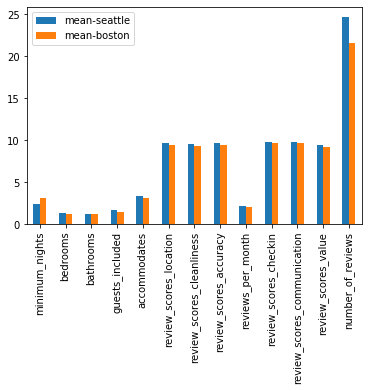

             mean-seattle  mean-boston
price_float        124.62       171.25


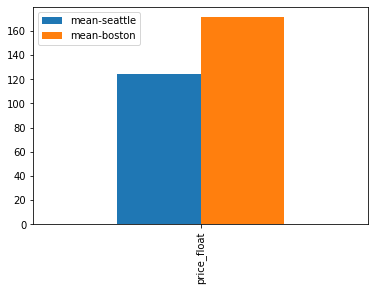

                      mean-seattle  mean-boston
review_scores_rating         94.54        92.02


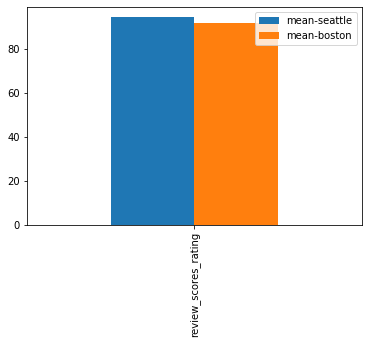

In [20]:
# summarize price, reviews and property attributes in a single summary
# create list of columns containing review string
review_columns = [col for col in filled_cleaned_listings_df.columns if 'review' in col] 

# create list of additional columns of interest
specific_columns = ['minimum_nights'
                   , 'bedrooms'
                   , 'bathrooms'
                   , 'guests_included'
                   , 'accommodates']

# create a combine list of numeric columns of interest
numeric_columns_to_describe = specific_columns + review_columns

# review_scores_rating has different magnitude so should be plotted seprately
numeric_columns_to_describe.remove('review_scores_rating')

# compare selected numeric columns
utils.compare_specified_float_columns(filled_cleaned_listings_df, numeric_columns_to_describe, 'mean')

# compare price
utils.compare_specified_float_columns(filled_cleaned_listings_df, ['price_float'], 'mean')

# compare review score
utils.compare_specified_float_columns(filled_cleaned_listings_df, ['review_scores_rating'], 'mean')

# create list of numeric columns to use in analysis
numeric_columns_to_describe = numeric_columns_to_describe + ['host_since_year', 'review_scores_rating']
# Price mean is higher in Boston but raitings mean is higher in Seattle

**2.** Visualize difference in prices depending on categorical data


In [21]:
# 4.2. describe relationship between price and categorical values between two cities

# create list of string columns that have up to 6 different values in oder to make categorical predictors
values_freq = {}
for col in filled_cleaned_listings_df.select_dtypes(include=['object']):
    values_freq[col] = len(filled_cleaned_listings_df[col].drop_duplicates())
values_freq = {k: v for k, v in sorted(values_freq.items(), key=lambda item: item[1], reverse=False)}

# judjing by the amount of the distinct values in the categorical columns it makes sense to use only those with
# less of 6 distinct values as columns with more distinct values would create 
# a large amount of dimentions while not adding much to explanatory power
values_freq = {k: v for k, v in filter(lambda item: 1 < item[1] < 6, values_freq.items())}
categorical_columns_to_describe = set(values_freq.keys())
print(categorical_columns_to_describe)

{'room_type', 'bed_type', 'host_response_time', 'instant_bookable', 'require_guest_phone_verification', 'host_identity_verified', 'require_guest_profile_picture', 'is_location_exact', 'host_is_superhost', 'cancellation_policy', 'host_has_profile_pic'}


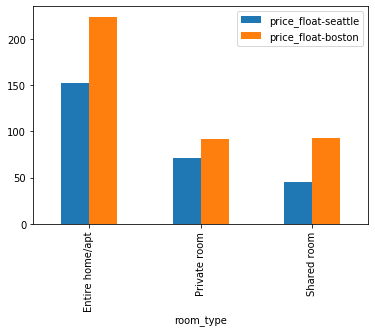

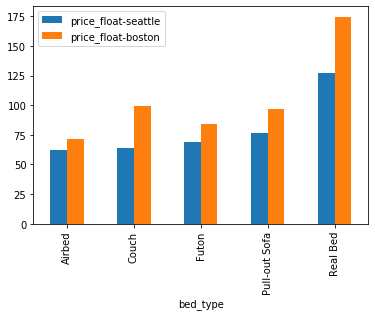

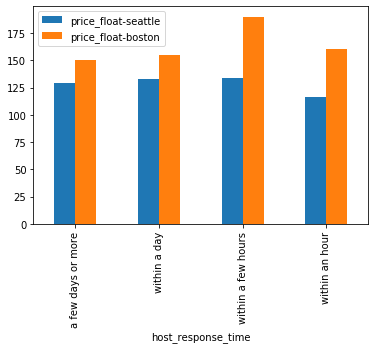

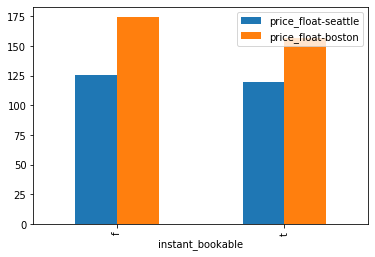

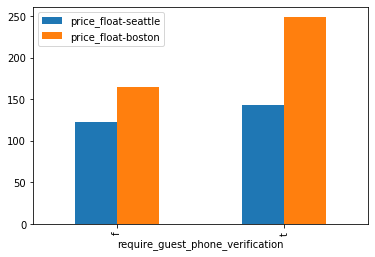

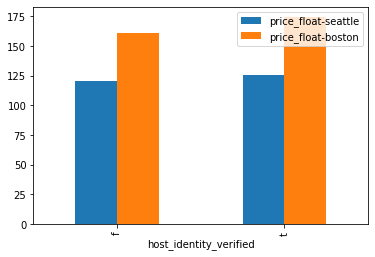

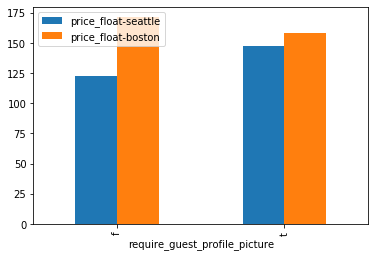

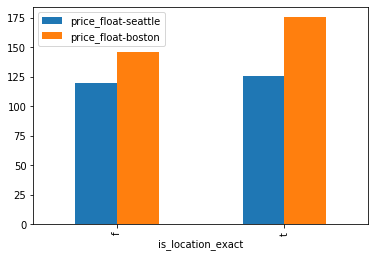

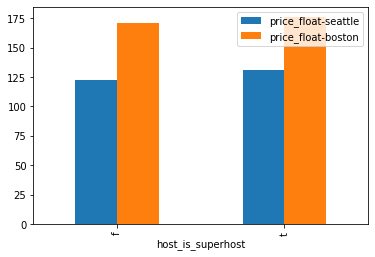

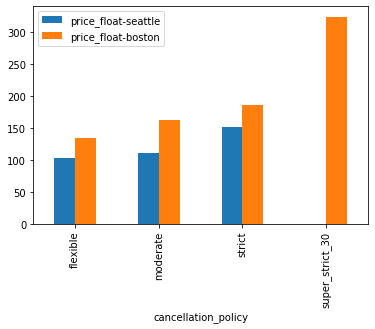

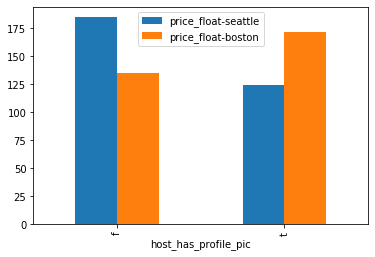

In [22]:
# compare numeric data across 2 cities grouping on each categorical column of interest
for col in categorical_columns_to_describe:
    utils.compare_grouby_results(filled_cleaned_listings_df, [col], ['price_float'], 'mean')
#Boston has a premium for fast responses but not for the fastest
#Boston has super stric policy -> the stricter the policy the more expensive
#Super host has little effect
#Airbeds in seattle seem to be more appreciated than couches

In [23]:
print(categorical_columns_to_describe)

{'room_type', 'bed_type', 'host_response_time', 'instant_bookable', 'require_guest_phone_verification', 'host_identity_verified', 'require_guest_profile_picture', 'is_location_exact', 'host_is_superhost', 'cancellation_policy', 'host_has_profile_pic'}


**3.** Create dummies for selected categorical data in listing_df


In [24]:
# 4.3. create dummies for selected categorical variables
# keep only the columns of interest
filled_cleaned_listings_df = filled_cleaned_listings_df[['boston', 'price_float'] + list(numeric_columns_to_describe) + list(categorical_columns_to_describe)]

for col in categorical_columns_to_describe:
    # for each cat add dummy var, drop original column
    filled_cleaned_listings_df = pd.concat([filled_cleaned_listings_df.drop(col, axis=1)
                                        , pd.get_dummies(filled_cleaned_listings_df[col]
                                                         , prefix=col, prefix_sep='_', drop_first=True)], axis=1)


**4.** Create dummies in calendar_df

In [25]:
# 4.4. Create city, year, city-year interaction dummies in calendar_df
calendar_df['2017_year'] = np.where(calendar_df['date_year'] == '2017', 1, 0)
calendar_df['2017_year_boston'] = calendar_df['2017_year'].multiply(calendar_df['boston'])

In [26]:
#4.5. create monthly dummies to check what is the best month to com
monthly_calendar_df = pd.concat([calendar_df.drop('date_month', axis=1)
                            , pd.get_dummies(calendar_df['date_month']
                                             , prefix='month', prefix_sep='_', drop_first=True)], axis=1)
monthly_calendar_df = monthly_calendar_df.drop(columns=['date_year'])

In [27]:
# list of month dummy columns
monthly_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
# create interactions between boston dummy and month dummies
for col in monthly_columns:
    monthly_calendar_df['boston_' + col] = monthly_calendar_df['boston']*monthly_calendar_df[col]

#### CRISP-DM: MODELING

**LISTINGS DATASET**

**1.** Run a simple linear regression useing price_float as a LHS variable and Boston dummy as a RHS variable. This can tell what city has on avarage more expensive flats. But this result is not final as price of the flats can be determined not by the city per se but by other attributes.

**2.** Include review scores and physical attributes of properties as RHS. This allows to see if the city location remains a strong predictor of the prices or other attributes are more important. In addition, it also can tell if review scores have a greater impact on the price than actual attributes of properties.

**CALENDAR DATA**

**1.** Run a simple linear regression useing price_float as a LHS variable and Boston dummy as a RHS variable. This is not conclusive result either but it is interesting if the simialr regression analysis produces a similar result when using different dataset.

**2.** Include 2017-year dummy and 2017-year--boston dummy. This can help to identify the price trend change in time between two cities. Unfortunately, the data is not ideal fo this analysis as Seattle has only January reported for 2017 so this estimate can be biased by seasonality. The resutls sould be interpreted as following:

**a)** The baseline for the compariosn is Seattle 2016. 

**b)** Boston dummy shows how Boston prices on average differed from Seattle prices in 2016.

**c)** 2017-year dummy shows how Seattle average price change in 2017 comparing to 2016.

**d)** Sum of 2017-year dummy and 2017-year--boston dummy shows how Boston average price change in 2017 comparing to 2016.

**3.** To address the issue of the seasonality mentions in point **2** I add monthly dummies and month--boston interactions in s RHS. 

**4.** I also run a seasonality only regression where I exclude year dummies from the regression in order to estimate average seasonal price fluctuation in both cities separately. In this case the coefficients should interpreted as following.

**a)** Comparison base is Seattle January.

**b)** Boston dummy shows difference between Boston and Seattle in January on average,.

**c)** Each monthly dummy shows deviation of the price in Seattle in this month from average January price in Seattle.

**d)** Sum of month dummies and month--boston dummies for each month shows how Boston average price deviates in this particular month comparing to January.



#### STEP 5. MODEL DATA

**1.** Run linear regression on listings data study the predictors of the prices in two cities

In [28]:
# 5.1.1. Check what city is on average more expensive
city_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'])
city_results['coefficients'].head()
#Boston is more expensive

,Coefficient
boston,46.81


In [29]:
print(city_results['r2_test'])
# Boston seem to be a more expensive city but just having one regressor does not explain much of price volatility

0.05002210382935135


In [30]:
# 5.1.2. Check if reviews are stronger price predictors than bed and bathrooms
numeric_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'] + numeric_columns_to_describe)
numeric_results['coefficients'].head(len(numeric_columns_to_describe) + 1)
# Boston remains a strong predictor of price even holding everything else constant
# Bedrooms, accomodates and bathrooms are as stronger predictors than reviews but score of location matters a lot as well
# Raiting does not matter
# Value score is negaative as expected because if signals a good deal
# Having a host with longer experience does not increase prices

,Coefficient
boston,59.12
review_scores_location,24.57
bedrooms,22.41
bathrooms,21.59
accommodates,19.83
review_scores_cleanliness,10.13
guests_included,2.53
review_scores_rating,0.82
review_scores_accuracy,0.68
minimum_nights,0.15


In [31]:
print(numeric_results['r2_test'])
# Boston is a strong predictor of price, quality of location is also important as well as size of the appartment

0.5064806505620368


In [32]:
# 5.1.3. Check if categorical values are stronger predictors than numeric predictors
columns_of_interest = list(filled_cleaned_listings_df.columns)
columns_of_interest.remove('price_float')
total_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], columns_of_interest)
total_results['coefficients'].head(len(columns_of_interest)+1)
# Phone verification is associated with more expensive accomodations
# Couch is more expensive than a real bed
# Host that replies in couple of hours earns more than host replyiong within an hour? 
# Number of reviews have negative effect on price

,Coefficient
cancellation_policy_super_strict_30,130.30
boston,55.45
bedrooms,29.04
bathrooms,28.82
bed_type_Couch,21.14
review_scores_location,15.97
require_guest_phone_verification_t,12.81
host_is_superhost_t,12.02
bed_type_Real Bed,10.80
accommodates,9.11


In [33]:
print(total_results['r2_test'])

0.569892035976125


**2.** Run linear regression on calendar data to see appartment price seasonality and time trend

In [44]:
# 5.2.1. Check if prices decreased in 2017
columns_of_interest = ['boston']
city_comp_result = utils.run_linear_regression(calendar_df, ['price_float'], columns_of_interest)
city_comp_result['coefficients'].head(len(columns_of_interest)+1)

,Coefficient
boston,60.50


In [34]:
# 5.2.1. Check if prices decreased in 2017
columns_of_interest = ['2017_year', 'boston', '2017_year_boston']
trends_results = utils.run_linear_regression(calendar_df, ['price_float'], columns_of_interest)
trends_results['coefficients'].head(len(columns_of_interest)+1)
# Boson is +75 in 2016
# seattle prices decreased by 2 dollars in 2017
# Boston prices decreased  by about 21 dollars in 2017

,Coefficient
boston,75.32
2017_year,-1.94
2017_year_boston,-19.14


In [35]:
columns_of_interest = [col for col in monthly_calendar_df.columns if 'month_' in col] 

In [36]:
# 5.2.3. Check what month is cheapest for tourists
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , columns_of_interest + ['boston','2017_year','2017_year_boston'])
monthly_results['coefficients'].head(len(columns_of_interest)+3)
# The sign of 2017_year flips to positive 
# suggeting that seattle prices increased in 2017 in comparison to 2016 rather than dropped
# the reason is that now we control for seasonality and previously we saw the effect of 
# having only relatively cheaper winter months for 2017 seattle dataset

,Coefficient
boston,121.69
month_07,30.20
month_08,28.73
month_06,26.01
month_09,21.72
month_05,17.91
month_12,15.46
month_10,14.99
2017_year,14.33
month_11,14.29


In [37]:
# list of interaction columns
monthly_interaction_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
# run linear regression
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , monthly_interaction_columns + ['boston'])
# regression coeficients
monthly_results['coefficients'].head(len(monthly_interaction_columns)+3)

,Coefficient
boston,59.83
boston_month_10,36.93
boston_month_09,33.95
month_07,28.94
month_08,27.47
month_06,24.75
month_09,20.46
month_05,16.65
month_12,14.20
month_10,13.73


In [38]:
# 5.2.5. combine coefficients for Seattle and Boston to infere overall change of prices in Boston in comparison to January
# sort coefificients_df to have boston and seattle coefficients distinctly
coefficients_df = monthly_results['coefficients'].sort_index()
# select only boston coefficients, reset index so boston-month will match seattle-month on index
boston_coefficients_df = coefficients_df[coefficients_df.index.str.contains('boston') 
                                         & (coefficients_df.index != 'boston')].reset_index(drop=True)
# select only seattle coefficients, reset index so boston-month will match seattle-month on index
seattle_coefficients_df = coefficients_df[~coefficients_df.index.str.contains('boston')].reset_index(drop=True)

In [39]:
# merge seatle and boston data
seasonality_df = boston_coefficients_df.merge(seattle_coefficients_df, left_index=True, right_index=True)
# rename index somit is more user friendly names
seasonality_df.index = ['Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']

In [40]:
# rename columns
seasonality_df.columns = ['Season_Impact_Boston', 'Season_Impact_Seattle']
# the comparison base for interaction dummies is January in Seattle, 
# other coefficients is the difference from January in Seattle
# so coefficient on Boston is the difference in price between Boston and Seattle in January
# difference between Seattle Jan and August is coefficient on month_8
# difference between Boston Jan and August is sum of coefficients on month_8 and boston_month_08
# so to compare seasonality I need to compute total seasonality impact in Boston
seasonality_df['Season_Impact_Boston'] = seasonality_df['Season_Impact_Boston'] + seasonality_df['Season_Impact_Seattle']

In [41]:
# Sort values for Boston
seasonality_df[['Season_Impact_Boston']].sort_values('Season_Impact_Boston').head(11)

,Season_Impact_Boston
Feb,-1.82
March,-0.50
Dec,9.55
May,11.84
June,13.33
April,14.97
July,19.60
Nov,19.68
Aug,20.11
Oct,50.67


In [42]:
# Sort values for Seattle
seasonality_df[['Season_Impact_Seattle']].sort_values('Season_Impact_Seattle').head(11)         

,Season_Impact_Seattle
Feb,1.54
March,5.82
April,11.96
Nov,13.03
Oct,13.73
Dec,14.20
May,16.65
Sep,20.46
June,24.75
Aug,27.47


#### CRISP-DM: EVALUATION

**LISTINGS DATASET**

**1.** Run a simple linear regression useing price_float as a LHS variable and Boston dummy as a RHS variable.

**BOSTON IS MORE EXPENSIVE AS EXPECTED. THIS WAS EVEIDENT FROM SIMPLE DESCRIPTIVE ANALYSIS.**

**2.** Include review scores and physical attributes of properties as RHS. 

**ACTUAL PHYSICAL ATTRIBUTES HAVE A LARGER IMPACT ON PRICE THAN REVIEW SCORES.**

**CALENDAR DATA**

**1.** Run a simple linear regression useing price_float as a LHS variable and Boston dummy as a RHS variable. This is not conclusive result either but it is interesting if the simialr regression analysis produces a similar result when using different dataset.

**SAME RESULT IS CONFIRMED AS IN LISTINGS DATASET. BOSTON IS MORE EXPENSIVE**

**2.** Include 2017-year dummy and 2017-year--boston dummy. This can help to identify the price trend change in time between two cities. Unfortunately, the data is not ideal fo this analysis as Seattle has only January reported for 2017 so this estimate can be biased by seasonality. The resutls sould be interpreted as following:

**a)** The baseline for the compariosn is Seattle 2016. 

**b)** Boston dummy shows how Boston prices on average differed from Seattle prices in 2016.

**c)** 2017-year dummy shows how Seattle average price change in 2017 comparing to 2016.

**d)** Sum of 2017-year dummy and 2017-year--boston dummy shows how Boston average price change in 2017 comparing to 2016.

**INCLUSION OF TIME DUMMIES CONFIRMS THAT BOSTON WAS MORE EXPENSIVE IN 2016 AND REMAINED MORE EXPENSIVE IN 2017 THOUGH IT EXPERIENCED A SHARPER PRICE DECLINE.**

**3.** To address the issue of the seasonality mentions in point **2** I add monthly dummies and month--boston interactions in s RHS. 

**INCLUSION OF MONTHLY DUMMIES CONFIRMS MY SUSPICION ABOUT THE INADEQUACY OF THE DATA FOR SEATTLE IN 2017. IF I CONTROL FOR SEASONALITY PRICES ACTUALLY INCREASE IN SEATTLE IN 2017 COMPARING TO 2016. OVERALL BOSTON REMAINED MORE EXPENSIVE IN BOTH YEARS**

**4.** I also run a seasonality only regression where I exclude year dummies from the regression in order to estimate average seasonal price fluctuation in both cities separately. This analysis can show when prices are on average the cheapes for tourists to visit. In this case the coefficients should interpreted as following.

**a)** Comparison base is Seattle January.

**b)** Boston dummy shows difference between Boston and Seattle in January on average,.

**c)** Each monthly dummy shows deviation of the price in Seattle in this month from average January price in Seattle.

**d)** Sum of month dummies and month--boston dummies for each month shows how Boston average price deviates in this particular month comparing to January.

**Q1 IS THE CHEAPEST TIME FOR VISITING BOTH CITIES WHILE SEATTLE IS MOST EXPENSIVE IN SUMMER AND BOSTIN IN AUTUMN.**